In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
import datetime

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from matplotlib import pyplot as plt
import os

# Download dan ekstrak dataset (dari kaggle)

Kode di bawah dapat berjalan jika terdapat file `kaggle.json` yang berisi username dan token dari kaggle API

In [2]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


Download dataset

In [3]:
!kaggle datasets download -d shivamb/underwater-surface-temperature-dataset

underwater-surface-temperature-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


Ekstrak dataset

In [4]:
!unzip "/content/underwater-surface-temperature-dataset.zip" -d "/content/underwater-surface-temperature-dataset"

Archive:  /content/underwater-surface-temperature-dataset.zip
replace /content/underwater-surface-temperature-dataset/underwater_temperature.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


# Load dataset menjadi pandas dataframe

In [5]:
df= pd.read_csv('/content/underwater-surface-temperature-dataset/underwater_temperature.csv', encoding='unicode_escape')

df

,ID,Site,Latitude,Longitude,Date,Time,Temp (°C),Depth
0,1,Ilha Deserta,27.2706,48.3310,2013/02/20,11:40:02,24.448,12.0
1,2,Ilha Deserta,27.2706,48.3310,2013/02/20,12:00:03,24.448,12.0
2,3,Ilha Deserta,27.2706,48.3310,2013/02/20,12:20:04,24.545,12.0
3,4,Ilha Deserta,27.2706,48.3310,2013/02/20,12:40:05,24.448,12.0
4,5,Ilha Deserta,27.2706,48.3310,2013/02/20,13:00:06,24.351,12.0
...,...,...,...,...,...,...,...,...
408633,408634,lha do Xavier,27.6092,48.3858,2013/03/07,09:03:29,24.931,5.0
408634,408635,lha do Xavier,27.6092,48.3858,2013/03/07,09:23:29,24.931,5.0
408635,408636,lha do Xavier,27.6092,48.3858,2013/03/07,09:43:29,24.931,5.0
408636,408637,lha do Xavier,27.6092,48.3858,2013/03/07,10:03:29,24.931,5.0


Kolom `Site` merupakan tempat pengukuran suhu, sedangkan kolom `Depth` merupakan kedalaman pengukuran suhu. Terdapat beberapa jenis tempat dan kedalaman pengukuran, maka dari itu kita terlebih dahulu perlu mendefinisikan tempat dan kedalaman pengukuran dengan melakukan filter pada dataframe.

In [6]:
df= df[(df['Site']=='Ilha Deserta') & (df['Depth']==12.0)]

df

,ID,Site,Latitude,Longitude,Date,Time,Temp (°C),Depth
0,1,Ilha Deserta,27.2706,48.331,2013/02/20,11:40:02,24.448,12.0
1,2,Ilha Deserta,27.2706,48.331,2013/02/20,12:00:03,24.448,12.0
2,3,Ilha Deserta,27.2706,48.331,2013/02/20,12:20:04,24.545,12.0
3,4,Ilha Deserta,27.2706,48.331,2013/02/20,12:40:05,24.448,12.0
4,5,Ilha Deserta,27.2706,48.331,2013/02/20,13:00:06,24.351,12.0
...,...,...,...,...,...,...,...,...
48165,48166,Ilha Deserta,27.2706,48.331,2014/12/21,11:18:25,26.488,12.0
48166,48167,Ilha Deserta,27.2706,48.331,2014/12/21,11:38:25,26.585,12.0
48167,48168,Ilha Deserta,27.2706,48.331,2014/12/21,11:58:25,26.585,12.0
48168,48169,Ilha Deserta,27.2706,48.331,2014/12/21,12:18:25,26.683,12.0


Plot dataset.

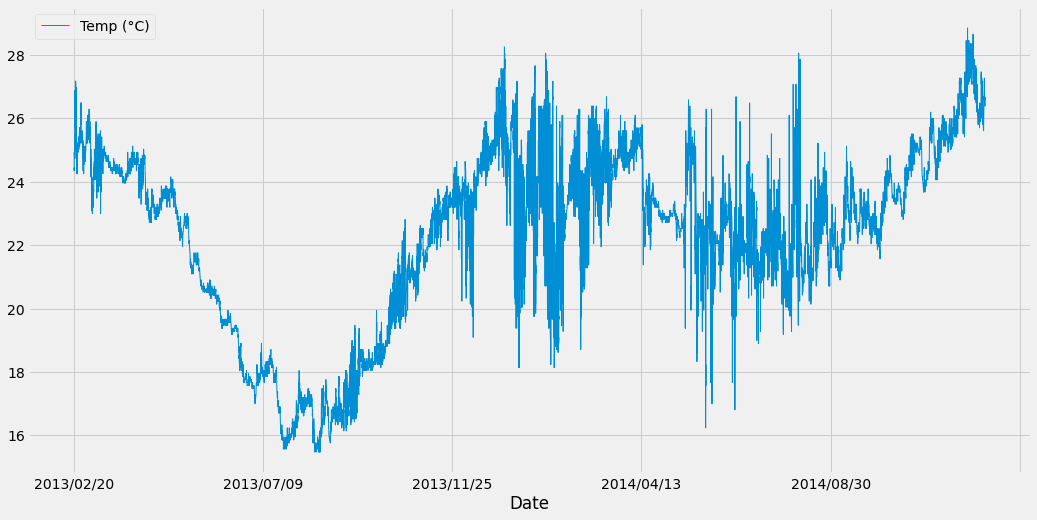

In [8]:
plt.style.use('fivethirtyeight')
df.plot(kind='line', x='Date', y='Temp (°C)', figsize=(16,8), lw=1)

Kita bisa menyimpulkan dataset berpola *noise*.

# Pra-Proses data

Pertama .kita menghapus beberapa kolom karena sudah tidak membutuhkannya

In [9]:
df= df.drop(['ID', 'Site', 'Latitude', 'Longitude', 'Depth'], axis=1)
df.columns= ['date', 'time', 'temp']

df

,date,time,temp
0,2013/02/20,11:40:02,24.448
1,2013/02/20,12:00:03,24.448
2,2013/02/20,12:20:04,24.545
3,2013/02/20,12:40:05,24.448
4,2013/02/20,13:00:06,24.351
...,...,...,...
48165,2014/12/21,11:18:25,26.488
48166,2014/12/21,11:38:25,26.585
48167,2014/12/21,11:58:25,26.585
48168,2014/12/21,12:18:25,26.683


Mengecek jika terdapat nilai null.

In [10]:
df.isna().any()

date    False
time    False
temp    False
dtype: bool

### Ekstraksi fitur

Eksraksi fitur dari kolom `date` dan `time`, namun terlebih dahulu kita perlu melakukan casting pada kolom tersebut menjadi kolom `datetime`.

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48170 entries, 0 to 48169
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    48170 non-null  object 
 1   time    48170 non-null  object 
 2   temp    48170 non-null  float64
dtypes: float64(1), object(2)
memory usage: 1.5+ MB


In [12]:
df['date']= pd.to_datetime(df['date'])
df['time'] = pd.to_datetime(df['time'])

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48170 entries, 0 to 48169
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    48170 non-null  datetime64[ns]
 1   time    48170 non-null  datetime64[ns]
 2   temp    48170 non-null  float64       
dtypes: datetime64[ns](2), float64(1)
memory usage: 1.5 MB


In [13]:
df['day'] = df['date'].dt.dayofyear
df['hour'] = df['time'].dt.hour
df['minute'] = df['time'].dt.minute

### Splitting data

Kita split data berdasarkan hari, 80% hari pertama menjadi data train dan sisanya menjadi data test.

In [14]:
train_scale= 0.8
threshold_days= len(df['date'].unique())*train_scale
threshold_date= df['date'].min()+datetime.timedelta(days=threshold_days)

train_df= df[df['date']<threshold_date]
test_df= df[df['date']>=threshold_date]

train_df

,date,time,temp,day,hour,minute
0,2013-02-20,2022-08-05 11:40:02,24.448,51,11,40
1,2013-02-20,2022-08-05 12:00:03,24.448,51,12,0
2,2013-02-20,2022-08-05 12:20:04,24.545,51,12,20
3,2013-02-20,2022-08-05 12:40:05,24.448,51,12,40
4,2013-02-20,2022-08-05 13:00:06,24.351,51,13,0
...,...,...,...,...,...,...
38551,2014-08-09,2022-08-05 22:38:25,20.996,221,22,38
38552,2014-08-09,2022-08-05 22:58:25,20.996,221,22,58
38553,2014-08-09,2022-08-05 23:18:25,20.996,221,23,18
38554,2014-08-09,2022-08-05 23:38:25,20.996,221,23,38


Menghapus kolom `date` dan `time` karena kita tidak membutuhkannya lagi.

In [15]:
df= df.drop(['date', 'time'], axis=1)
train_df= train_df.drop(['date', 'time'], axis=1)
test_df= test_df.drop(['date', 'time'], axis=1)

train_df.head()

,temp,day,hour,minute
0,24.448,51,11,40
1,24.448,51,12,0
2,24.545,51,12,20
3,24.448,51,12,40
4,24.351,51,13,0


### Normalisasi

In [16]:
scaler = MinMaxScaler()

scaler.fit(df)
train_data = scaler.transform(train_df)

train_data

array([[0.67077728, 0.13736264, 0.47826087, 0.6779661 ],
       [0.67077728, 0.13736264, 0.52173913, 0.        ],
       [0.67802691, 0.13736264, 0.52173913, 0.33898305],
       ...,
       [0.41278027, 0.6043956 , 1.        , 0.30508475],
       [0.41278027, 0.6043956 , 1.        , 0.6440678 ],
       [0.41278027, 0.6043956 , 1.        , 0.98305085]])

### Sliding Window

In [17]:
window_size= 72

x_train= []
y_train= []

for i in range(window_size, len(train_data)):
    x_train.append(train_data[i-window_size:i])
    y_train.append(train_data[i, 0])

x_train[0][:5]

array([[0.67077728, 0.13736264, 0.47826087, 0.6779661 ],
       [0.67077728, 0.13736264, 0.52173913, 0.        ],
       [0.67802691, 0.13736264, 0.52173913, 0.33898305],
       [0.67077728, 0.13736264, 0.52173913, 0.6779661 ],
       [0.66352765, 0.13736264, 0.56521739, 0.        ]])

In [18]:
past_days = train_df.tail(window_size)
test_df = past_days.append(test_df, ignore_index=True)
test_data = scaler.transform(test_df)

x_test= []
y_test= []

for i in range(window_size, test_df.shape[0]):
    x_test.append(test_data[i-window_size:i])
    y_test.append(test_data[i, 0])

In [19]:
x_train, y_train= np.array(x_train), np.array(y_train)
x_test, y_test= np.array(x_test), np.array(y_test)

x_train.shape, x_test.shape

((38484, 72, 4), (9614, 72, 4))

# Modeling

In [20]:
model= keras.Sequential([
    keras.layers.Input(x_train.shape[1:]),
    keras.layers.LSTM(256, 'tanh', return_sequences= True),
    keras.layers.Dropout(0.2),
    keras.layers.LSTM(256, 'tanh'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(1)
])

optimizer= keras.optimizers.Adam(learning_rate=1e-03)
loss=tf.keras.losses.Huber()

In [21]:
model.compile(loss=loss,
              optimizer=optimizer,
              metrics=["mae"])

reduce_lr= keras.callbacks.ReduceLROnPlateau(monitor='mae', factor= 0.5, patience=1, min_lr=1e-5, min_delta=5e-4)
early_stopping= keras.callbacks.EarlyStopping(monitor='mae', min_delta=1e-5, patience=10, mode='auto')

In [22]:
history = model.fit(x_train, y_train, epochs=30, batch_size=64, validation_data=(x_test, y_test), callbacks=[reduce_lr, early_stopping])

Epoch 1/30
602/602 [==============================] - 15s 17ms/step - loss: 0.0015 - mae: 0.0329 - val_loss: 1.8502e-04 - val_mae: 0.0149 - lr: 0.0010
Epoch 2/30
602/602 [==============================] - 10s 16ms/step - loss: 7.0473e-04 - mae: 0.0256 - val_loss: 7.7060e-05 - val_mae: 0.0088 - lr: 0.0010
Epoch 3/30
602/602 [==============================] - 9s 15ms/step - loss: 5.8638e-04 - mae: 0.0231 - val_loss: 1.5302e-04 - val_mae: 0.0157 - lr: 0.0010
Epoch 4/30
602/602 [==============================] - 10s 16ms/step - loss: 5.2528e-04 - mae: 0.0216 - val_loss: 6.0438e-05 - val_mae: 0.0079 - lr: 0.0010
Epoch 5/30
602/602 [==============================] - 9s 16ms/step - loss: 4.9495e-04 - mae: 0.0207 - val_loss: 4.0134e-05 - val_mae: 0.0065 - lr: 0.0010
Epoch 6/30
602/602 [==============================] - 9s 16ms/step - loss: 4.6289e-04 - mae: 0.0198 - val_loss: 1.3705e-04 - val_mae: 0.0136 - lr: 0.0010
Epoch 7/30
602/602 [==============================] - 9s 16ms/step - loss: 4.

### Plot MAE dan Loss selama proses pelatihan

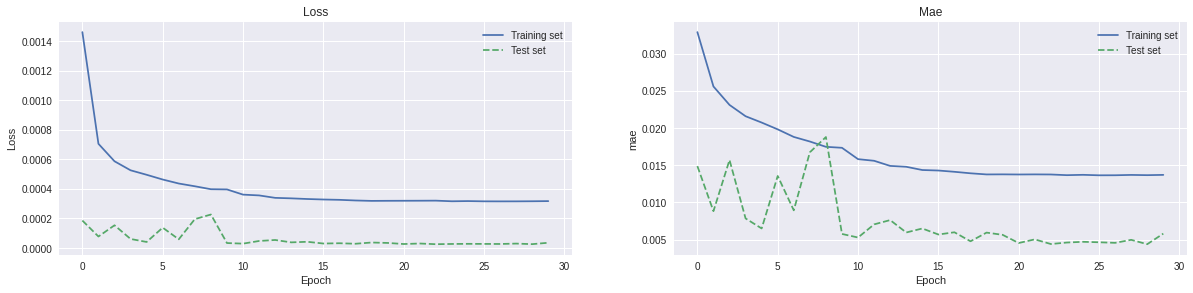

In [23]:
plt.style.use('seaborn')

loss= history.history['loss']
val_loss= history.history['val_loss']

mae= history.history['mae']
val_mae= history.history['val_mae']

plt.figure(figsize=(18, 4))

plt.subplot(1, 2, 1)
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(loss, label='Training set')
plt.plot(val_loss, label='Test set', linestyle='--')
plt.legend()

plt.subplot(1, 2, 2)
plt.title('Mae')
plt.xlabel('Epoch')
plt.ylabel('mae')
plt.plot(mae, label='Training set')
plt.plot(val_mae, label='Test set', linestyle='--')
plt.legend()

plt.show()

### Plot perbandingan suhu yang diprediksi dengan suhu sebenarnya

In [24]:
y_pred= model.predict(x_test)

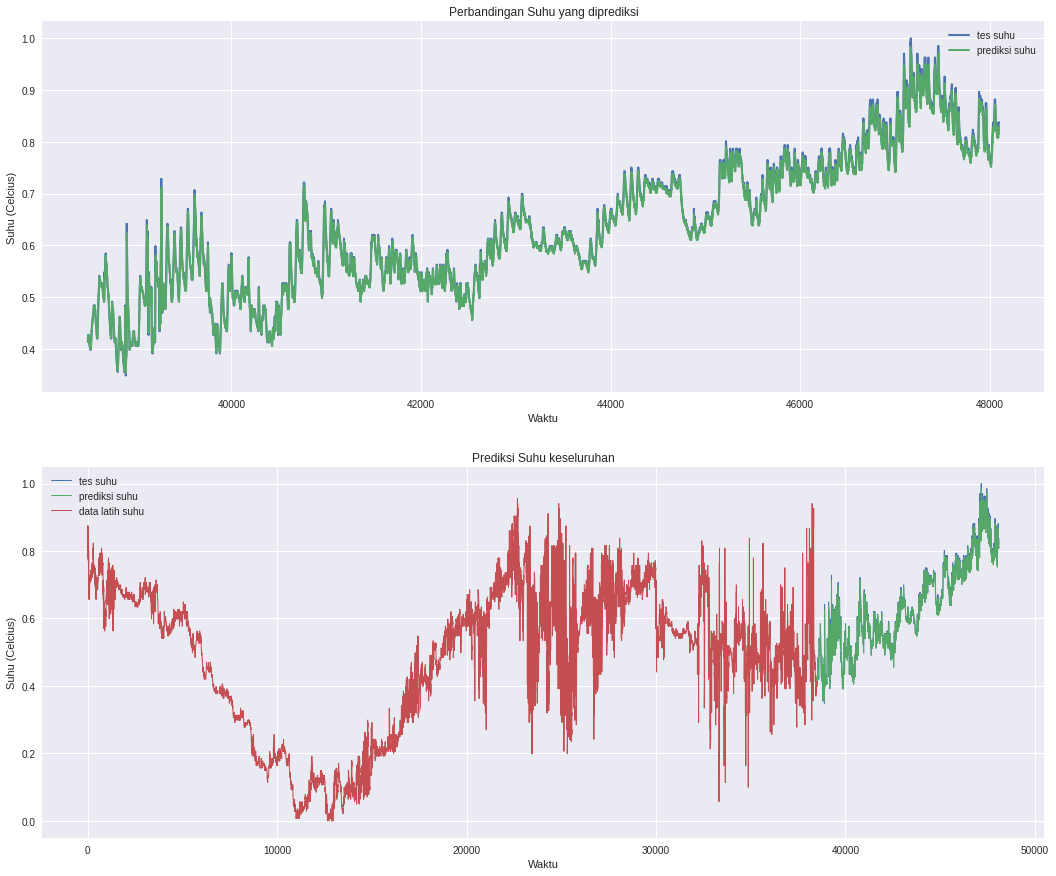

In [25]:
fig = plt.figure(figsize=(16,14))

ax_1 = fig.add_subplot(211)
ax_2 = fig.add_subplot(212)

ax_1.plot(np.arange(len(y_train), len(y_train)+len(y_test)), y_test, label = 'tes suhu', linewidth= 2)
ax_1.plot(np.arange(len(y_train), len(y_train)+len(y_test)), y_pred, label = 'prediksi suhu', linewidth= 2)

ax_1.set_title('Perbandingan Suhu yang diprediksi')
ax_1.set_xlabel('Waktu')
ax_1.set_ylabel('Suhu (Celcius)')
ax_1.legend()

ax_2.plot(np.arange(len(y_train), len(y_train)+len(y_test)), y_test, label = 'tes suhu', linewidth= 1)
ax_2.plot(np.arange(len(y_train), len(y_train)+len(y_test)), y_pred, label = 'prediksi suhu', linewidth= 1)
ax_2.plot(np.arange(len(y_train)), y_train, label = 'data latih suhu', linewidth= 1)

ax_2.set_title('Prediksi Suhu keseluruhan')
ax_2.set_xlabel('Waktu')
ax_2.set_ylabel('Suhu (Celcius)')
ax_2.legend()

plt.subplots_adjust(hspace = 0.2)
plt.show()